# Description

In [ ]:
# INFORMATION:

# This file lists the films in the MIAS database and provides     
# appropriate details as follows:

# 1st column: MIAS database reference number.

# 2nd column: Character of background tissue: 
#                 F - Fatty 
#                 G - Fatty-glandular
#                 D - Dense-glandular

# 3rd column: Class of abnormality present:
#                 CALC - Calcification
#                 CIRC - Well-defined/circumscribed masses
#                 SPIC - Spiculated masses
#                 MISC - Other, ill-defined masses
#                 ARCH - Architectural distortion
#                 ASYM - Asymmetry
#                 NORM - Normal

# 4th column: Severity of abnormality;
#                 B - Benign
#                 M - Malignant
                
# 5th,6th columns: x,y image-coordinates of centre of abnormality.

# 7th column: Approximate radius (in pixels) of a circle enclosing
# 	    the abnormality.
	    
# NOTES
# =====
# 1) The list is arranged in pairs of films, where each pair 
#    represents the left (even filename numbers) and right mammograms
#    (odd filename numbers) of a single patient.
   
# 2) The size of ALL the images is 1024 pixels x 1024 pixels. The images
#    have been centered in the matrix.  

# 3) When calcifications are present, centre locations and radii 
#    apply to clusters rather than individual calcifications.
#    Coordinate system origin is the bottom-left corner.

# 4) In some cases calcifications are widely distributed throughout
#    the image rather than concentrated at a single site. In these
#    cases centre locations and radii are inappropriate and have
#    been omitted.

# Info Load

In [1]:
path = '/content/drive/MyDrive/Colab Notebooks/breast_cancer/data/all-mias/'

import os
files = os.listdir(path)
files = [file for file in sorted(files) if file.endswith('pgm')]

import pandas as pd

# 짝수는 왼쪽 / 홀수는 오른쪽 (같은 환자)
# 아이디가 중복되는 pgm이 있음(8건) 좌표와 radius만 다르고 나머지는 같음 --> 여러 abnormal을 찾은것같음
# x = *NOTE y= 3*로 되어있는 abnormal이 3건있음
# 같은환자여도 오른쪽/왼쪽에 따라 Normal상태가 다름
# target: 4th column 
names = ['pgm', 
         'Character of background tissue',
         'Class of abnormality present',
         'Severity of abnormality',
         'x',
         'y',
         'radius']

info = pd.read_csv(path+'Info.txt', sep=' ', skiprows=101, names=names, skipfooter=1)


#label
info['label'] = info['Class of abnormality present'].apply(lambda x: 0 if x == "NORM" else 1)
print('label proportion')
print(info['label'].value_counts())

labels = info.drop_duplicates('pgm')['label'].values


### 이상치
# info.query(' y == "3*"')
# info.query(' x == "*NOTE"')

###중복
# dup = info[info.pgm.duplicated()].pgm.values
# info.query('pgm in @dup')

display(info.head(3))

label proportion
0    207
1    123
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


,pgm,Character of background tissue,Class of abnormality present,Severity of abnormality,x,y,radius,label
0,mdb001,G,CIRC,B,535,425,197.0,1
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,NaN,None,None,NaN,0


# Image Load / Augmentation

In [ ]:
img.shape[:-1]

(224, 224)

In [2]:
import cv2
import numpy as np
from tqdm.notebook import tqdm

def read_image_aug(name):
  global img

  file = name + '.pgm'
  img = cv2.imread(path + file)[:, :, :] #/ 255 #####채널을 3개 다받는 것으로 수정 # numpy에서 255로 나누면 램부족... --> tensor에서 나누어줌
  img = cv2.resize(img, (224, 224)) # (224, 224, 3)

  # opening (erosion -> dilation)
  kernel = np.ones((3, 3), np.uint8)
  img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)

  rows, cols = img.shape[:-1] # (224, 224)
  
  # augmentation
  aug = []
  no_angles = 360
  
  for angle in range(0, no_angles, 8):
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) # 회전중심 , 회전각도, 확대
    img_rotated = cv2.warpAffine(img, M, (cols, rows)) #그림, 그림회전, (새세로, 새가로)
    aug.append(img_rotated)
  
  return np.array(aug)


# make X, y
X = []
y = []

unNormal = info.dropna(subset=['Severity of abnormality']).drop_duplicates('pgm')
print(unNormal['Severity of abnormality'].value_counts())

for name, label in tqdm(unNormal.iloc[:, [0, 3]].values):
  
  #image augmentation
  X.append(read_image_aug(name))

  #Benign #양성
  if label == 'B': 
    y.append(np.zeros((45, 1)))

  #Malignant #악성 #target
  else: 
    y.append(np.ones((45, 1)))

  
X = np.moveaxis(np.concatenate(X), -1, 1)#[:, np.newaxis, :, :] #np.moveaxis로 차원변경
y = np.concatenate(y)

print(X.shape, y.shape)

B    64
M    51
Name: Severity of abnormality, dtype: int64



(5175, 3, 224, 224) (5175, 1)


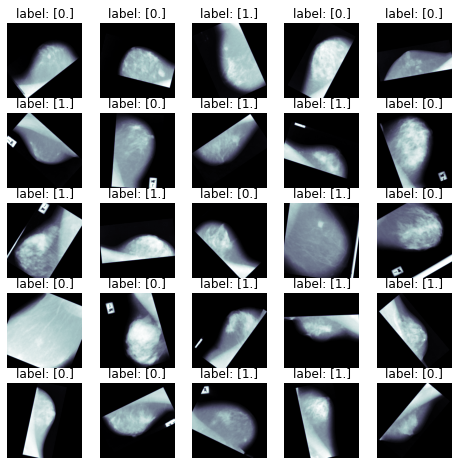

In [3]:
import matplotlib.pyplot as plt
n = 0
plt.figure(figsize=(8, 8))
for i in range(5):
  for j in range(5):
    n += 1
    plt.subplot(5, 5, n)
    plt.imshow(X[n*151,0], cmap=plt.cm.bone) #3 채널이 모두 같은 값이라 하나의 채널만 확인
    plt.title(f'label: {y[n*151]}')
    plt.axis('off')

Number of different Pixels:  10512


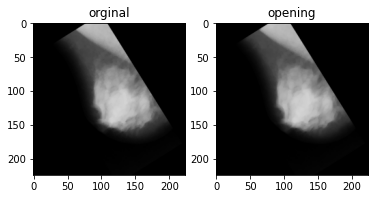

In [4]:
img = np.moveaxis(X[4], 0, -1)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('orginal')

img_open = img.copy()
kernel = np.ones((3, 3), np.uint8)
img_open = cv2.morphologyEx(img_open, cv2.MORPH_OPEN, kernel)

plt.subplot(1, 2, 2)
plt.imshow(img_open)
plt.title('opening')

print('Number of different Pixels: ',224*224*3 - np.equal(img, img_open).sum())

# Label Proportion / Baseline

Text(0.5, 1.0, 'Label Ratio')

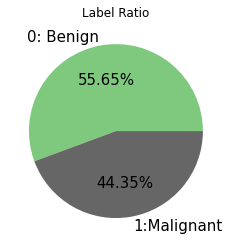

In [5]:
pd.Series(y.flatten()).value_counts().plot.pie(cmap=plt.cm.Accent, label='', labels=['0: Benign', '1:Malignant'], fontsize=15, autopct='%0.2f%%')
plt.title('Label Ratio', fontsize=12)

# make DataLoader / Split Data

In [6]:
import torch
import random
import torchvision
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproductabliity
random.seed(111)
torch.manual_seed(777)
if DEVICE == 'cuda':
  torch.cuda.manual_seed(777)
  torch.cuda.manual_seed_all(777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(111)

X_tensor = torch.Tensor(X)/255 # numpy에서 255로 나누면 램부족... --> tensor에서 나누어줌
y_tensor = torch.Tensor(y)

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

train_size = 3000 
val_size = 1100
test_size = 1075
BATCH_SIZE = 64

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size + val_size, test_size])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print('train_dataset: ', len(train_dataset)) 
print('val_dataset: ', len(val_dataset)) 
print('test_dataset: ', len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE)


train_dataset:  3000
val_dataset:  1100
test_dataset:  1075


# model


In [7]:

class transferClassifier:

  def __init__(self, hidden_size, dropout_rate=0):

    self.hidden_size = hidden_size
    self.dropout_rate = dropout_rate
    self.load_model() # 모델 불러오기
    self.freeze_layer() # 레이어 동결
    self.finetune() # fc layer 미세조정
    
  def __new__(cls, hidden_size, dropout_rate=0):

      instance = super(transferClassifier, cls).__new__(cls)
      instance.__init__(hidden_size, dropout_rate)
      return instance.model

  # 참조: https://pytorch.org/vision/stable/models.html
  def load_model(self):
    self.model = torchvision.models.resnet18(pretrained=True, progress=True)
    # self.model = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
    # self.model = torchvision.models.wide_resnet50_2(pretrained=True, progress=True)
    
  # 학습시 가중치가 바뀌지 않게 고정
  def freeze_layer(self):
    for param in self.model.parameters():
      param.requires_grad = False
  
  # 원하는 출력에 맞게 fc layer를 수정
  def finetune(self):
    num_ftrs = self.model.fc.in_features
    print(f'num_ftrs: {num_ftrs}', end='\n\n')

    print('original fc layer: ', end='\n')
    print(self.model.fc, end='\n\n')
    
    # 마지막 fc layer를 데이터에 맞게 변경
    
    self.model.fc = torch.nn.Sequential(
        torch.nn.Linear(num_ftrs, self.hidden_size),
        torch.nn.BatchNorm1d(self.hidden_size),
        torch.nn.ReLU(),
        # torch.nn.Dropout(self.dropout_rate), # 과적합방지

        torch.nn.Linear(self.hidden_size, 1),
        torch.nn.Sigmoid()
        )
    
    print('changed fc layer: ', end='\n')
    print(self.model.fc)

#모델 생성
model = transferClassifier(32, 0.1)

num_ftrs: 512

original fc layer: 
Linear(in_features=512, out_features=1000, bias=True)

changed fc layer: 
Sequential(
  (0): Linear(in_features=512, out_features=32, bias=True)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=1, bias=True)
  (4): Sigmoid()
)


In [8]:
from torchsummary import summary

summary(model.to(DEVICE), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Train

In [9]:
# validation용

def evaluate(model, loader):
  
  # 평가모드
  model.eval()
  eval_loss = 0.0
  eval_acc = 0.0

  with torch.no_grad():

    for image, label in loader:

      image = image.to(DEVICE)
      label = label.to(DEVICE)
      pred = model(image)

      eval_loss += criterion(pred, label).item()
      
      #acc
      label_pred = pred.round()
      eval_acc += (label == label_pred).sum()

  eval_loss = eval_loss / len(loader)
  eval_acc = eval_acc / len(loader.dataset)
  
  return eval_loss, eval_acc

In [10]:
# 모델 초기가중치 설정
def init_weights(m):
    
    if type(m) == torch.nn.Linear:
      torch.nn.init.kaiming_uniform_(m.weight)

In [17]:
# train용

def train(model, epochs):
  
  global criterion
  
  # 손실함수
  criterion = torch.nn.BCELoss()
  # 옵티마이저 
  optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.01) # fc layer만 학습에 사용
  losses = {'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []}

  for epoch in range(epochs):
    print('Epoch: {:0>4}...'.format(epoch+1), end='\t')
    
    #train모드
    model.train()
    running_loss = 0.0
    running_acc = 0

    for i, (image, label) in enumerate(train_loader):

      image = image.to(DEVICE)
      label = label.to(DEVICE)
      # 변화도 초기화
      optimizer.zero_grad()

      #예측
      pred = model(image)
      
      #손실계산
      loss = criterion(pred, label)
      
      #정확도 계산
      label_pred = pred.round()
      running_acc += (label == label_pred).sum()
      
      #역전파
      loss.backward()

      #가중치 갱신
      optimizer.step()
      
      #손실값 갱신 
      running_loss += loss.item()


    # 학습성능 확인
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader.dataset)

    losses['train_loss'].append(train_loss)
    losses['train_acc'].append(train_acc)

    print('train_loss: {:.4f}'.format(train_loss), end='\t')
    print('train_acc: {:.4f}'.format(train_acc), end='\t\t')
    
    # validation
    val_loss, val_acc = evaluate(model, val_loader)
    
    losses['val_loss'].append(val_loss)
    losses['val_acc'].append(val_acc)

    print('val_loss: {:.4f}'.format(val_loss), end='\t')
    print('val_acc: {:.4f}'.format(val_acc))
    print()
  
  return losses 


#모델 생성
model = transferClassifier(64, 0.3) # (hidden_size, dropout_rate)

#모델 초기 가중치 적용
model.apply(init_weights)

#모델학습
losses = train(model.to(DEVICE), 30) # (model, epochs)

num_ftrs: 512

original fc layer: 
Linear(in_features=512, out_features=1000, bias=True)

changed fc layer: 
Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=1, bias=True)
  (4): Sigmoid()
)
Epoch: 0001...	train_loss: 0.6377	train_acc: 0.6487		val_loss: 0.6040	val_acc: 0.6827

Epoch: 0002...	train_loss: 0.4576	train_acc: 0.7890		val_loss: 0.6223	val_acc: 0.6845

Epoch: 0003...	train_loss: 0.3290	train_acc: 0.8697		val_loss: 0.5188	val_acc: 0.7609

Epoch: 0004...	train_loss: 0.2073	train_acc: 0.9343		val_loss: 0.5081	val_acc: 0.7800

Epoch: 0005...	train_loss: 0.1152	train_acc: 0.9750		val_loss: 0.7024	val_acc: 0.7300

Epoch: 0006...	train_loss: 0.0660	train_acc: 0.9887		val_loss: 0.9855	val_acc: 0.7136

Epoch: 0007...	train_loss: 0.0644	train_acc: 0.9797		val_loss: 1.5156	val_acc: 0.6545

Epoch: 0008...	train_loss: 0.0903	

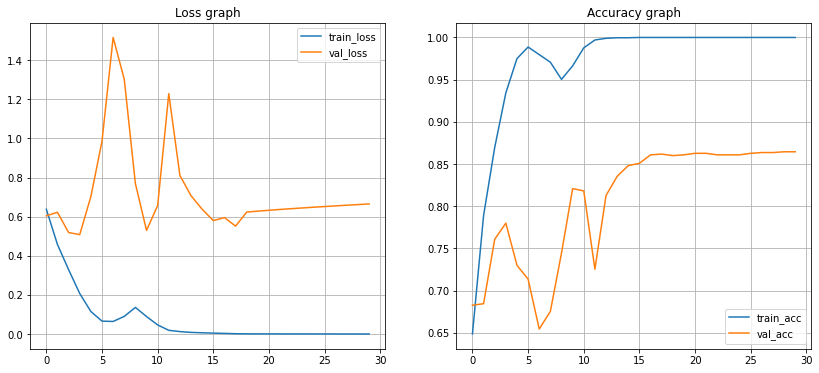

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(losses['train_loss'], label='train_loss')
plt.plot(losses['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)
plt.title('Loss graph')

plt.subplot(1, 2, 2)
plt.plot(losses['train_acc'], label='train_acc')
plt.plot(losses['val_acc'], label='val_acc')
plt.legend()
plt.grid(True)
plt.title('Accuracy graph')
plt.show()

# Predict / Evaluate

In [19]:
loss, acc = evaluate(model, test_loader)
print('test_loss: {:.4f}, test_acc: {:.4f}'.format(loss, acc))

test_loss: 0.5060, test_acc: 0.8605


In [20]:
# test set 예측

tl = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset))

model.eval()
with torch.no_grad():

  for image, label in tl:

    image = image.to(DEVICE)
    pred = model(image)

f1 score:  0.8417721518987342
precision score:  0.8471337579617835
recall score:  0.8364779874213837


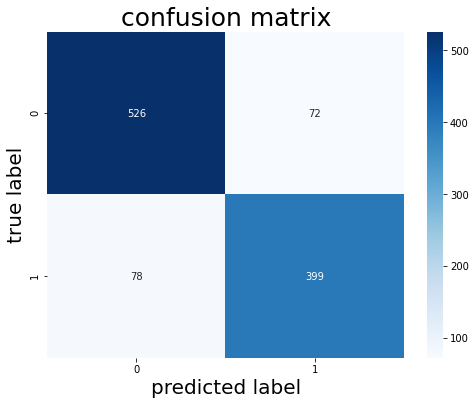

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

##confusion matrix
## metrics
## f1_score, precision, recall

# true, pred 순서
f1score = f1_score(label.cpu(), pred.cpu().round())
print('f1 score: ', f1score)


precision = precision_score(label.cpu(), pred.cpu().round())
print('precision score: ', precision)

recall = recall_score(label.cpu(), pred.cpu().round())
print('recall score: ', recall)

# true, pred 순서
cm = confusion_matrix(label.cpu(), pred.cpu().round())
tn, fp, fn, tp  = confusion_matrix(label.cpu(), pred.cpu().round()).ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix', fontsize=25)
plt.xlabel('predicted label', fontsize=20)
plt.ylabel('true label', fontsize=20)
plt.show()

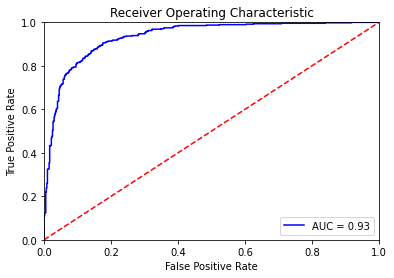

In [22]:
# ROC - AUC
#   실제 양성을 양성으로 예측하는것
# --------------------------------------
#  실제로 음성인데 양성으로 예측하는 것


import sklearn.metrics as metrics
# true, pred 순서
fpr, tpr, threshold = metrics.roc_curve(label.cpu(), pred.cpu())

roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()